<a href="https://colab.research.google.com/github/justinliu23/DME-project/blob/main/DME_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
try:
    %tensorflow_version 2.x
except:
    pass

print('Using TensorFlow Version:', tf.__version__)

! pip install tensorflow-addons
import tensorflow_addons as tfa
from tensorflow_addons.metrics import CohenKappa

import tensorflow.keras.backend as K
from tensorflow import GradientTape

from tensorflow.image import resize
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, Dense
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam

import seaborn as sns
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score, PrecisionRecallDisplay

import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

# ! pip install -U efficientnet
# from efficientnet.tfkeras import EfficientNetB7

Using TensorFlow Version: 2.7.0


In [ ]:
# Check GPU
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    print('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
# Authorize access to mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Tensorboard logs - Justin path
logs = r'/content/drive/MyDrive/Colab Notebooks/TB_logs'

In [ ]:
# Folder to save all models - specify model name at the end of filepath
# model_filepath = r'/content/drive/MyDrive/Colab Notebooks/Diabetic Retinopathy/models/DME_EfficientNet-B7'
model_filepath = r'/content/drive/MyDrive/Colab Notebooks/Diabetic Retinopathy/models/DME_ResNet50V2'

In [ ]:
training_dir   = r'/content/drive/MyDrive/Colab Notebooks/DME Project/OCT_extractions_balanced/Train'
validation_dir = r'/content/drive/MyDrive/Colab Notebooks/DME Project/OCT_extractions_balanced/Validation'
testing_dir    = r'/content/drive/MyDrive/Colab Notebooks/DME Project/OCT_extractions_balanced/Test'

In [ ]:
CLASSES = ['DME', 'Normal']

CHANNELS = 3
COLOR_MODE = 'rgb'

IMG_WIDTH, IMG_HEIGHT = 250, 250
TARGET_SIZE = (IMG_WIDTH, IMG_HEIGHT)
INPUT_SHAPE = (IMG_WIDTH, IMG_HEIGHT, CHANNELS)

LEARNING_RATE = 0.001 # default for Adam
MIN_DELTA = 1e-5
PATIENCE = 4
BATCH_SIZE = 32
EPOCHS = 5
PERCENTAGE_FACTOR = 100;
THRESHOLD_VALUE = 0.5

METRICS = ['accuracy',
           Precision(name='precision'),
           Recall(name='recall'),
           CohenKappa(num_classes=2)]

font_settings = {'family': 'DejaVu Sans',
                  'color' : 'red',
                  'weight': 'heavy',
                  'size'  :  11}

In [ ]:
training_data_gen = ImageDataGenerator(featurewise_center=True,     # set mean = 0
                                       rescale=1./255,              # Simplify pixel values to be 0-1
                                       horizontal_flip=True,        # Randomly flip images horizontally
                                       zoom_range=0.1,              # Randomly zoom
                                       shear_range=0.05,            # Shear angle in counter-clockwise direction
                                       rotation_range=5,            # Randomly rotate
                                       width_shift_range=0.03,      # Randomly shift the image left/right
                                       height_shift_range=0.03,     # Randomly shift the image up/down
                                       fill_mode='constant',        # Filling mode for points outside boundaries
                                      #  cval=0,                     # Value used for points outside the boundaries
                                       brightness_range=(0.97, 1.03)) # Randomly adjust the brightness
                                      #  preprocessing_function=      # 
                                      #  ____________)

validation_data_gen = ImageDataGenerator(featurewise_center=True,
                                         rescale=1./255)
                                        #  preprocessing_function=___)

testing_data_gen = ImageDataGenerator(featurewise_center=True,
                                      rescale=1./255)
                                      # preprocessing_function=_______)

In [ ]:
training_generator = training_data_gen.flow_from_directory(training_dir,
                                                           color_mode=COLOR_MODE,
                                                           target_size=TARGET_SIZE,
                                                           class_mode='binary',
                                                           batch_size=BATCH_SIZE,
                                                           shuffle=True)

validation_generator = validation_data_gen.flow_from_directory(validation_dir,
                                                               color_mode=COLOR_MODE,
                                                               target_size=TARGET_SIZE,
                                                               class_mode='binary',
                                                               batch_size=BATCH_SIZE,
                                                               shuffle=True)

testing_generator = testing_data_gen.flow_from_directory(testing_dir,
                                                         color_mode=COLOR_MODE,
                                                         target_size=TARGET_SIZE,
                                                         class_mode='binary',
                                                         batch_size=BATCH_SIZE,
                                                         shuffle=False)

Found 7820 images belonging to 2 classes.
Found 954 images belonging to 2 classes.
Found 960 images belonging to 2 classes.


In [ ]:
print(training_generator.class_indices)

{'dme': 0, 'normal': 1}


In [ ]:
def visualize_augmentations(data_generator):
    batch = data_generator.next()
    image_batch = batch[0]
    batch_labels = batch[1]

    fig, axs = plt.subplots(nrows=4, ncols=8, figsize=(24, 14), constrained_layout=True)
    batch_length = len(image_batch)

    for i, image in enumerate(image_batch):
        if int(batch_labels[i]) == 0:
            title = CLASSES[0]
            font_settings.update({'color': 'red'})
        else:
            title = CLASSES[1]
            font_settings.update({'color': 'blue'})

        if i < (1 / 4) * batch_length:
            axs[0, i].imshow(image_batch[i])
            axs[0, i].set_title(title, fontdict=font_settings)
            axs[0, i].axis('off')
        elif i < (2 / 4) * batch_length:
            axs[1, i - 8].imshow(image_batch[i])
            axs[1, i - 8].set_title(title, fontdict=font_settings)
            axs[1, i - 8].axis('off')
        elif i < (3 / 4) * batch_length:
            axs[2, i - 16].imshow(image_batch[i])
            axs[2, i - 16].set_title(title, fontdict=font_settings)
            axs[2, i - 16].axis('off')
        else:
            axs[3, i - 24].imshow(image_batch[i])
            axs[3, i - 24].set_title(title, fontdict=font_settings)     
            axs[3, i - 24].axis('off')   

    plt.show()

Training Batch:


This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.


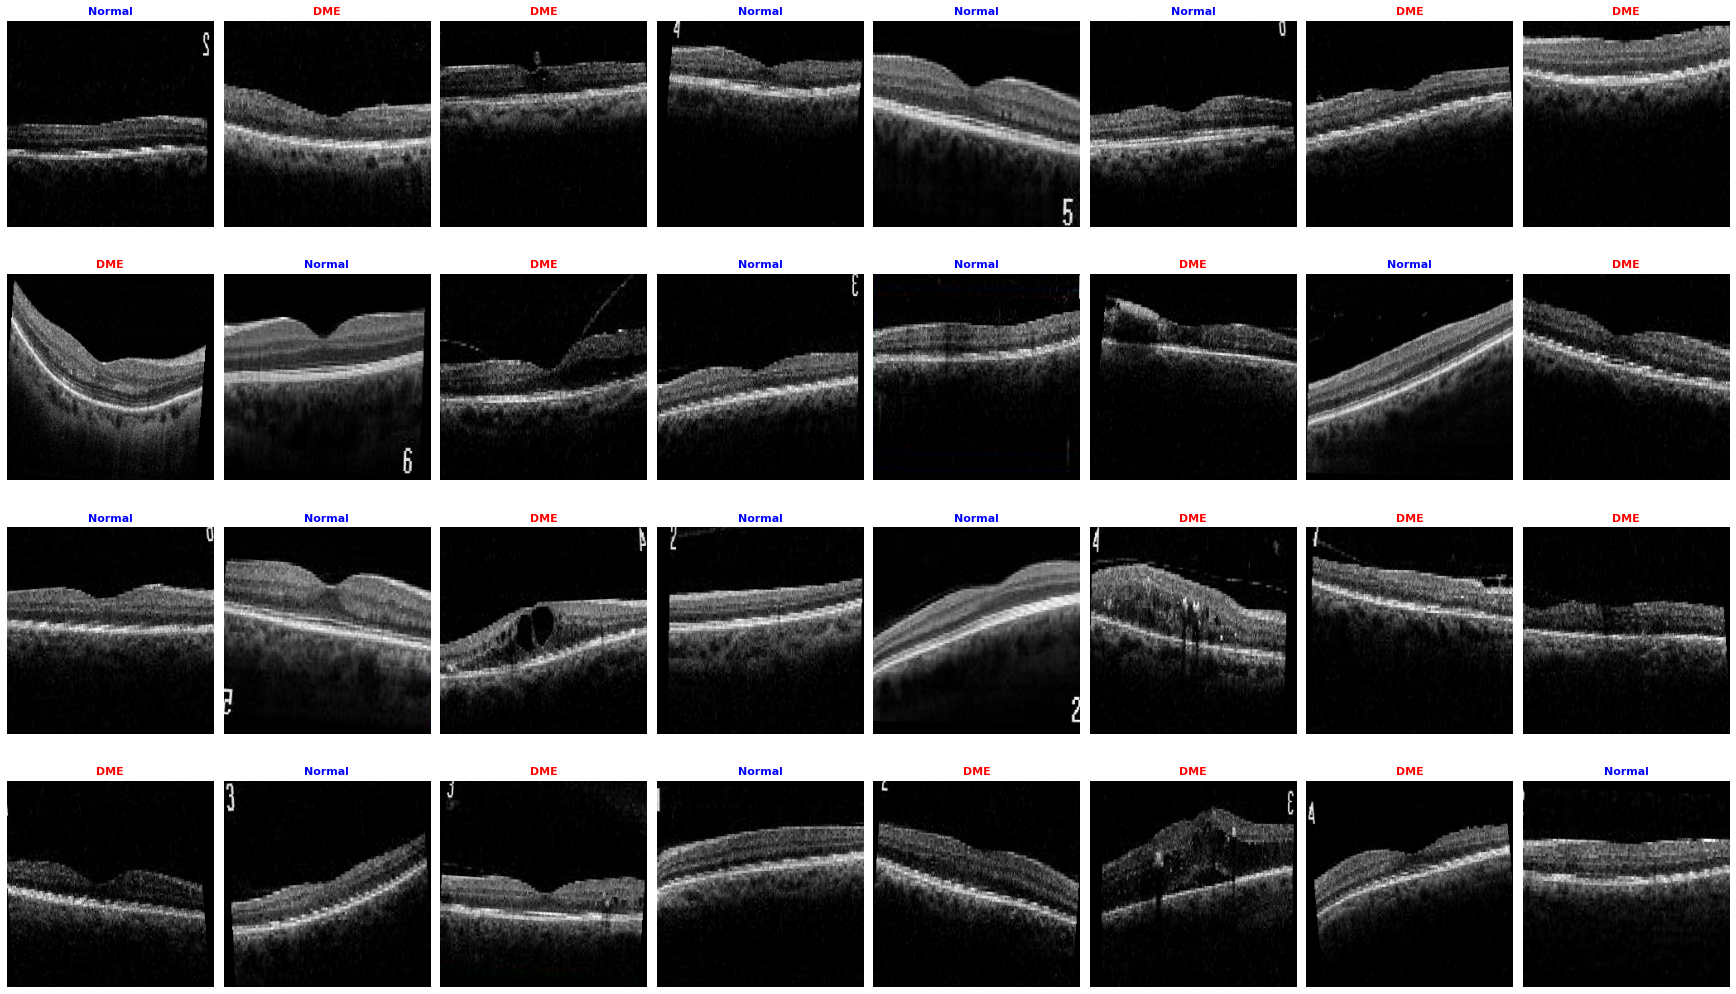




Validation Batch:


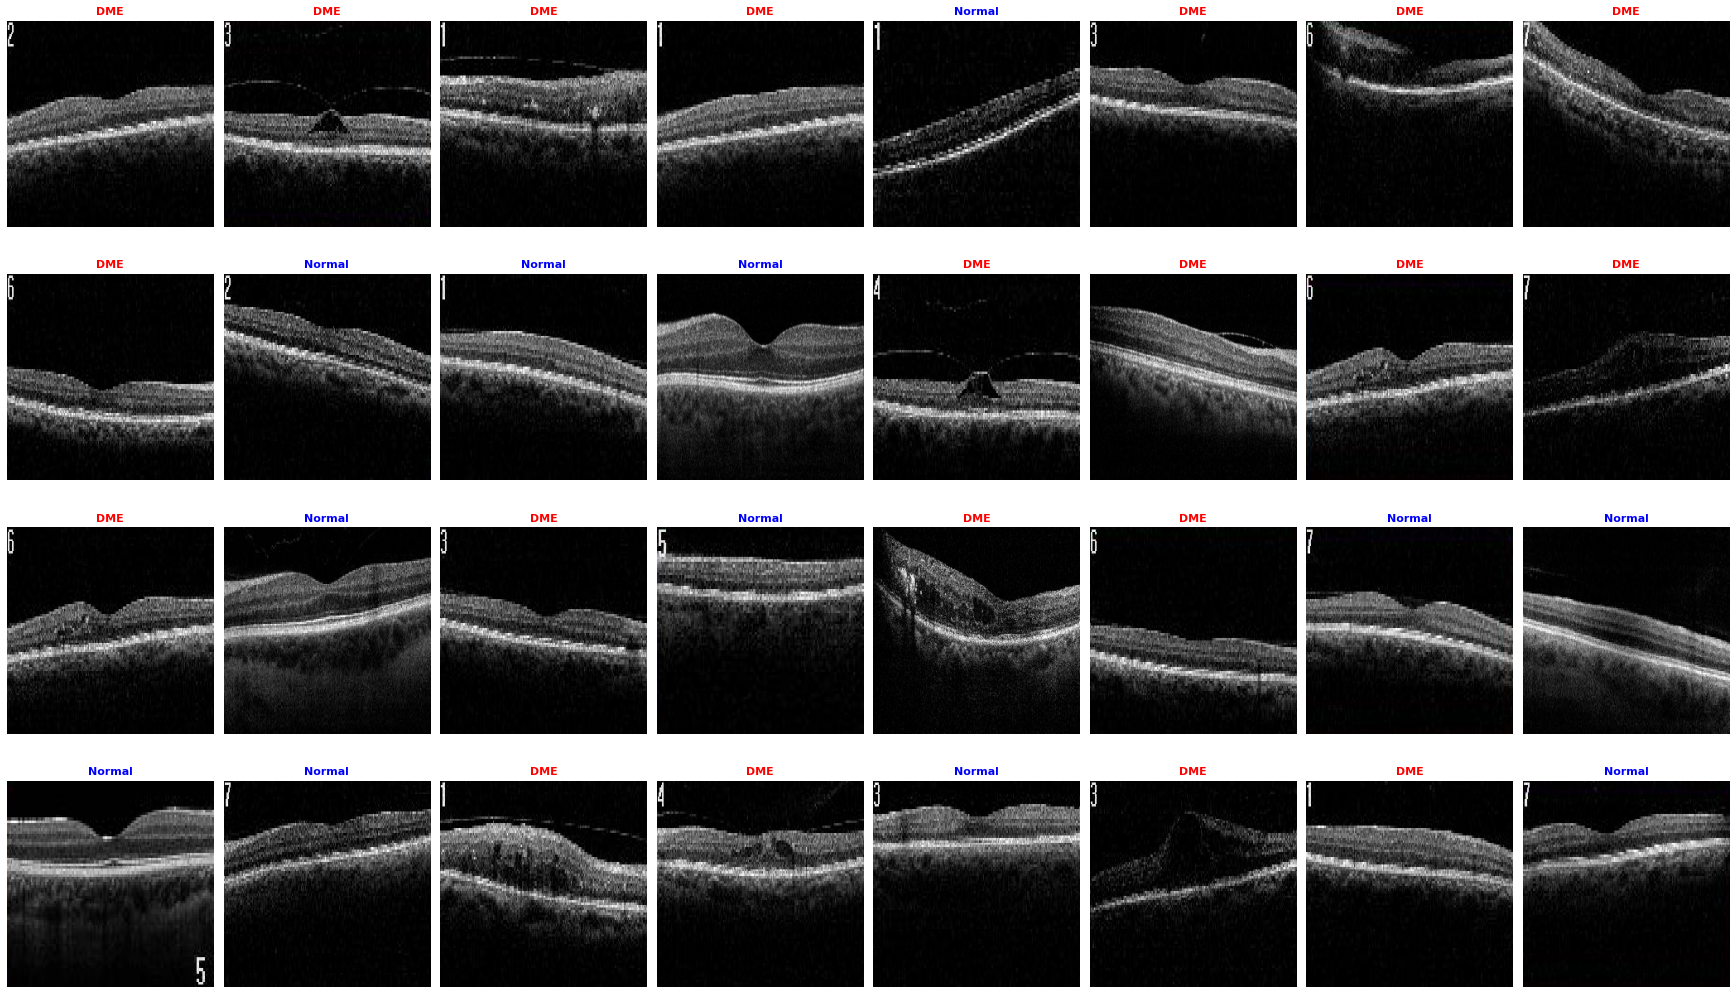

In [ ]:
print('Training Batch:')
visualize_augmentations(training_generator)
print('\n\n\nValidation Batch:')
visualize_augmentations(validation_generator)

In [ ]:
def create_model(print_summary=False):
    # Instantiate a base model with pre-trained weights
    base_model = tf.keras.applications.ResNet50V2(weights='imagenet',
    # base_model = tf.keras.applications.EfficientNetB7(weights='imagenet',
                                include_top=False,
                                input_shape=INPUT_SHAPE)
    # Freeze the base model
    for layer in base_model.layers:
        layer.trainable = False
        
    x = base_model.output

    # Add new layers to the end of the base model
    x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)

    # Add a final dense layer with a single neuron (logistic regression)
    predictions = Dense(1, activation="sigmoid")(x)

    model = Model(inputs=base_model.inputs, outputs=predictions)

    if print_summary:
        model.summary()

    return model

In [ ]:
def compile_model(model):
    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(learning_rate=LEARNING_RATE),
                  metrics=METRICS)

In [ ]:
def fit_model(model):
    early_stopping_cb = EarlyStopping(monitor='val_accuracy',
                                      min_delta=MIN_DELTA,
                                      patience=PATIENCE,
                                      mode='max',
                                      restore_best_weights=True)
    
    # log_dir = logs + r'/EfficientNet-B7'
    log_dir = logs + r'/DME_ResNet50V2'
    tensorboard_cb = TensorBoard(log_dir=log_dir,
                                 histogram_freq=1)
    
    callbacks = [early_stopping_cb, tensorboard_cb]
    
    history = model.fit(training_generator,
                        epochs=EPOCHS,
                        steps_per_epoch=(training_generator.n/BATCH_SIZE),
                        validation_data=validation_generator,
                        validation_steps=(validation_generator.n/BATCH_SIZE),
                        callbacks=callbacks)
    
    return history

In [ ]:
def evaluate_model(history):
    fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(30, 4), constrained_layout=True)

    # hand calculated F1-score, tfa's caused errors
    f1_scores = []
    # calculate f1-score from precision and recall
    for i in range(len(history.history['val_recall'])):
        if history.history['val_precision'][i] != 0 and history.history['val_recall'][i] != 0:
            f1_scores.append((2 * history.history['val_precision'][i] * history.history['val_recall'][i]) / (history.history['val_precision'][i] + history.history['val_recall'][i]))

    for i, metric in enumerate(['accuracy', 'loss', 'precision', 'recall', 'cohen_kappa']):
        axs[i].plot(history.history[metric])
        axs[i].plot(history.history['val_' + metric])
        axs[i].set_title('Model {}'.format(metric.capitalize()))
        axs[i].set_xlabel('Epochs')
        axs[i].set_ylabel(metric.capitalize())
        axs[i].legend(['Training', 'Validation'])
        
        if metric is not 'loss':
            non_zeros = [num for num in history.history['val_' + metric] if num != 0]
            avg = "{:.4f}".format(np.mean(non_zeros))
            std = "{:.4f}".format(np.std(non_zeros))
            se = "{:.4f}".format(float(std) / (validation_generator.n) ** 0.5)
            print(metric + ': {} ± {}'.format(avg, se))
    
    # print f1-score
    f1_score = "{:.4f}".format(f1_scores[-1])
    avg = "{:.4f}".format(np.mean(f1_scores))
    std = "{:.4f}".format(np.std(f1_scores))
    se = "{:.4f}".format(float(std) / (validation_generator.n) ** 0.5)
    print('final f1-score: ' + f1_score)
    print('f1-score' + ': {} ± {}'.format(avg, se))

In [ ]:
model = create_model(print_summary=False)
compile_model(model)

In [ ]:
history = fit_model(model)

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.


Epoch 1/5
488/488 [==============================] - 1625s 3s/step - loss: 0.4425 - accuracy: 0.7818 - precision: 0.7808 - recall: 0.7836 - cohen_kappa: 0.5637 - val_loss: 0.4398 - val_accuracy: 0.7788 - val_precision: 0.7262 - val_recall: 0.8952 - val_cohen_kappa: 0.5577
Epoch 2/5
488/488 [==============================] - 198s 406ms/step - loss: 0.3367 - accuracy: 0.8435 - precision: 0.8390 - recall: 0.8501 - cohen_kappa: 0.6870 - val_loss: 0.4873 - val_accuracy: 0.7694 - val_precision: 0.7096 - val_recall: 0.9119 - val_cohen_kappa: 0.5388
Epoch 3/5
488/488 [==============================] - 197s 402ms/step - loss: 0.3155 - accuracy: 0.8517 - precision: 0.8453 - recall: 0.8609 - cohen_kappa: 0.7033 - val_loss: 0.4338 - val_accuracy: 0.7736 - val_precision: 0.7254 - val_recall: 0.8805 - val_cohen_kappa: 0.5472
Epoch 4/5
488/488 [==============================] - 197s 403ms/step - loss: 0.2901 - accuracy: 0.8701 - precision: 0.8641 - recall: 0.8783 - cohen_kappa: 0.7402 - val_loss: 0.5

In [ ]:
model.save(model_filepath)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/Diabetic Retinopathy/models/DME_ResNet50V2/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/Diabetic Retinopathy/models/DME_ResNet50V2/assets
Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.


In [ ]:
# # load_in_model_filepath = r'/content/drive/MyDrive/Colab Notebooks/Diabetic Retinopathy/models/ResNet-50V2'
# model = load_model(model_filepath)

In [ ]:
sns.set_context("paper")
# sns.set_style("whitegrid")
sns.set_theme()

accuracy: 0.7715 ± 0.0002
precision: 0.7439 ± 0.0013
recall: 0.8403 ± 0.0025
cohen_kappa: 0.5430 ± 0.0004
final f1-score: 0.7571
f1-score: 0.7850 ± 0.0006


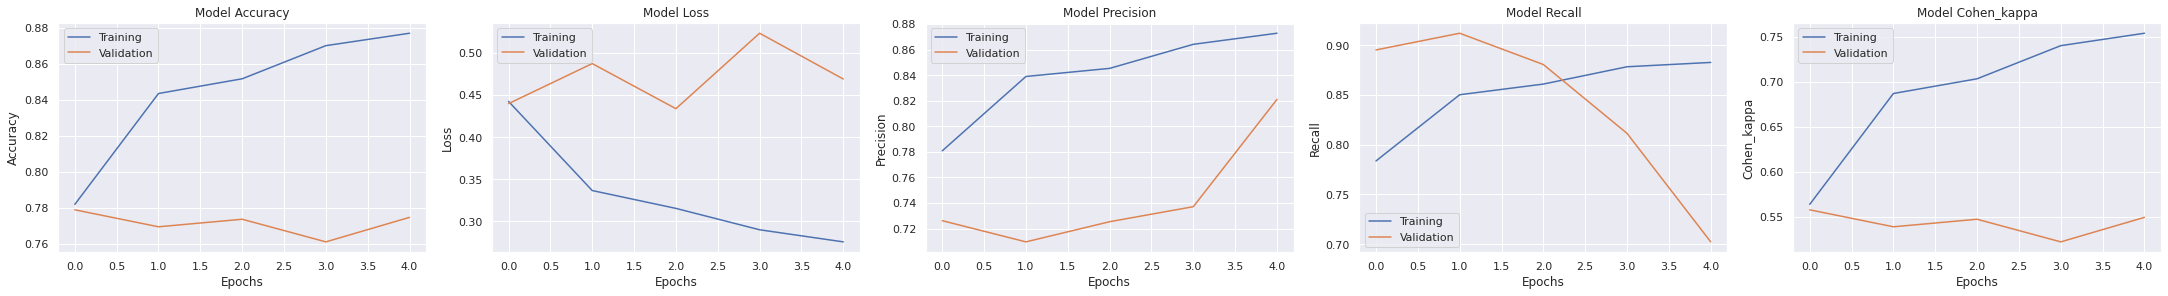

In [ ]:
evaluate_model(history)

In [ ]:
# def compute_specificity(model):
#     spec = []

#     for preds in enumerate(model):
#         false_positives = 0
#         false_negatives = 0
#         true_positives = 0
#         true_negatives = 0

#         for i in range(len(preds)):
#           if (preds[i] != validation_generator.labels[i] and validation_generator.labels[i] == 0):
#             false_positives+=1
#           elif (preds[i] != validation_generator.labels[i] and validation_generator.labels[i] == 1):
#             false_negatives+=1
#           elif (preds[i] == validation_generator.labels[i] and validation_generator.labels[i] == 0):
#             true_negatives+=1
#           elif (preds[i] == validation_generator.labels[i] and validation_generator.labels[i] == 1):
#             true_positives+=1

#         # print('true_positives', true_positives)
#         # print('true_negatives', true_negatives)
#         # print('false_negatives', false_negatives)
#         # print('false_positives', false_positives)

#         specificity = true_negatives / (true_negatives + false_positives)        
#         # precision = true_positives / (true_positives + false_positives)
#         # recall = true_positives / (true_positives + false_negatives)
#         # accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_negatives + false_positives)
#         # f1_score = 2*precision*recall / (precision+recall)

#         spec.append(specificity)

#     return spec

In [ ]:
# predictions = model.predict(testing_generator)
# rounded_predictions = np.around(predictions.copy()).astype(int)

In [ ]:
def grad_CAM(model, orig_img, intensity_factor=0.0015, plot=True):
    with GradientTape() as tape:
        # ResNet-50V2
        last_conv_layer = model.get_layer('conv5_block3_3_conv')
        # DenseNet-201
        # last_conv_layer = model.get_layer('conv5_block32_2_conv')
        # mobile
        # last_conv_layer = model.get_layer('conv_pw_13')
        # EB2
        # last_conv_layer = model.get_layer('top_conv')
        iterate = Model([model.inputs], [model.output, last_conv_layer.output])
        model_out, last_conv_layer = iterate(orig_img.reshape(1, IMG_WIDTH, IMG_HEIGHT, CHANNELS))
        class_out = model_out[:, np.argmax(model_out[0])]
        grads = tape.gradient(class_out, last_conv_layer)
        pooled_grads = K.mean(grads, axis=(0, 1, 2))

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    np.seterr(divide='ignore', invalid='ignore')
    heatmap /= np.max(heatmap)
    heatmap = heatmap.reshape(8, 8)
    # heatmap = heatmap.reshape(7, 7)

    heatmap = cv2.resize(heatmap, (orig_img.shape[1], orig_img.shape[0]))
    colormap = cv2.applyColorMap(np.uint8(heatmap * 255), cv2.COLORMAP_HSV)

    dimmed_heatmap = colormap * intensity_factor
    
    superimposed_img = ((dimmed_heatmap + orig_img) * 180).astype(np.uint8)

    if plot:
        plt.imshow(superimposed_img)
        plt.show()

    return superimposed_img, heatmap

In [ ]:
def guided_backprop(model, orig_img):
    # ResNet50-V2
    gb_model = Model(inputs = [model.inputs], outputs = [model.get_layer('conv5_block3_3_conv').output])
    # DenseNet-201
    # gb_model = Model(inputs = [model.inputs], outputs = [model.get_layer('conv5_block32_2_conv').output])
    # Mobile
    # gb_model = Model(inputs = [model.inputs], outputs = [model.get_layer('conv_pw_13').output])
    # EB2
    # gb_model = Model(inputs = [model.inputs], outputs = [model.get_layer('top_conv').output])

    with GradientTape() as tape:
        inputs = tf.cast(orig_img.reshape(1, IMG_WIDTH, IMG_HEIGHT, CHANNELS), tf.float32)
        tape.watch(inputs)
        outputs = gb_model(inputs)[0]
        bp_grads = tape.gradient(outputs,inputs)[0]
    
    guided_bp = bp_grads

    guided_bp = np.dstack((guided_bp[:, :, 0],
                           guided_bp[:, :, 1],
                           guided_bp[:, :, 2]))
                
    enhanced_guided_bp = guided_bp / guided_bp.max()
    guided_bp -= np.min(guided_bp)
    norm_guided_bp = guided_bp / guided_bp.max()

    return guided_bp, enhanced_guided_bp, norm_guided_bp

In [ ]:
def guided_gradcam(norm_guided_bp, enhanced_guided_bp, guided_cam):
    guided_gc = np.dstack((norm_guided_bp[:, :, 0] * guided_cam,
                           norm_guided_bp[:, :, 1] * guided_cam,
                           norm_guided_bp[:, :, 2] * guided_cam))

    # enhanced_guided_gc = np.dstack((enhanced_guided_bp[:, :, 0] * guided_cam * 5,
    #                                 enhanced_guided_bp[:, :, 1] * guided_cam * 5,
    #                                 enhanced_guided_bp[:, :, 2] * guided_cam * 5))
    
    enhanced_guided_gc = np.dstack((enhanced_guided_bp[:, :, 0] * guided_cam * 10,
                                    enhanced_guided_bp[:, :, 1] * guided_cam,
                                    enhanced_guided_bp[:, :, 2] * guided_cam))
    
    return guided_gc, enhanced_guided_gc

In [ ]:
def run_diagnosis(model, img_array):
    resized_img = np.asarray(resize(img_array, TARGET_SIZE)).astype(np.uint8)
    np.seterr(divide='ignore', invalid='ignore')
    resized_img = resized_img / 255

    testing_img = resized_img.reshape(1, IMG_WIDTH, IMG_HEIGHT, CHANNELS)
    prediction = model.predict(testing_img)[0][0]
    # print('Prediction:', prediction)

    # Safe prediction for DME positive
    if prediction > THRESHOLD_VALUE:
        class_index = 1
        network_prediction = CLASSES[class_index]

        network_percent_confidence = str(prediction * PERCENTAGE_FACTOR)[:5]
        
        font_settings.update({'color': 'red'})
        # plt.title(f'{network_prediction} ({network_percent_confidence}% match)', fontdict=font_settings)
        print(f'{network_prediction} ({network_percent_confidence}% match)')

    # Safe prediction for DME negative
    else:
        class_index = 0
        network_prediction = CLASSES[class_index]

        network_percent_confidence = str((1 - prediction) * PERCENTAGE_FACTOR)[:5]
        
        font_settings.update({'color': 'blue'})
        # plt.title(f'{network_prediction} ({network_percent_confidence}% match)', fontdict=font_settings)
        print(f'{network_prediction} ({network_percent_confidence}% match)')

    superimposed_img, guided_cam = grad_CAM(model, resized_img, intensity_factor=0.001, plot=False)
    guided_bp, enhanced_guided_bp, norm_guided_bp = guided_backprop(model, resized_img)
    guided_gc, enhanced_guided_gc = guided_gradcam(norm_guided_bp, enhanced_guided_bp, guided_cam)    

    # fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14, 14))
    # axs[0, 0].imshow(superimposed_img)
    # axs[0, 1].imshow(np.clip(norm_guided_bp, a_min=0, a_max=1))
    # axs[1, 0].imshow(np.clip(guided_gc, a_min=0, a_max=1))
    # axs[1, 1].imshow(np.clip(enhanced_guided_gc, a_min=0, a_max=1))

    # axs[0, 0].grid(False)
    # axs[0, 1].grid(False)
    # axs[1, 0].grid(False)
    # axs[1, 1].grid(False)

    plt.axis('off')
    plt.grid(False)
    plt.imshow(resized_img)
    plt.show()

    plt.axis('off')
    plt.grid(False)
    plt.imshow(superimposed_img)
    plt.show()

    plt.axis('off')
    plt.grid(False)
    plt.imshow(np.clip(norm_guided_bp, a_min=0, a_max=1))
    plt.show()

    plt.axis('off')
    plt.grid(False)
    plt.imshow(np.clip(guided_gc, a_min=0, a_max=1))
    plt.show()
    
    plt.axis('off')
    plt.grid(False)
    plt.imshow(np.clip(enhanced_guided_gc, a_min=0, a_max=1))   
    plt.show()

In [ ]:
batch = testing_generator.next()
image_batch = batch[0]
batch_labels = batch[1]

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.


True Label DME
Normal (79.30% match)


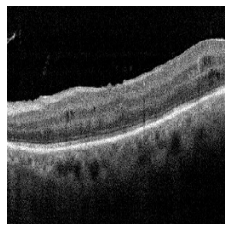

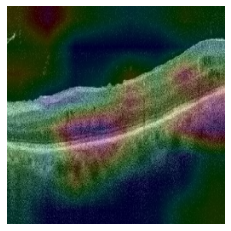

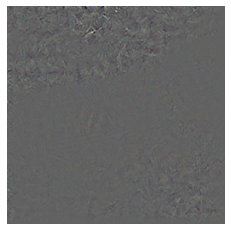

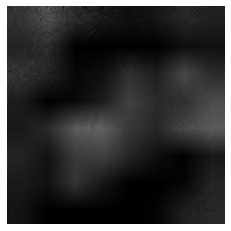

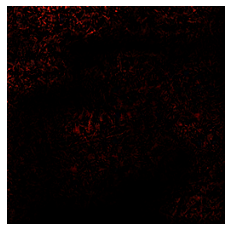

In [ ]:
#@title Run a Diagnostic Test {run: "auto", vertical-output: true}
image_index = 1 #@param {type:"slider", min:1, max:32, step:1}

testing_image = (image_batch[image_index - 1] * 255).astype(np.uint8)
true_label = CLASSES[int(batch_labels[image_index - 1])]
print('True Label', true_label)
run_diagnosis(model, img_array=testing_image)

In [ ]:
#                         [batch_num][images/labels]
batch2 = testing_generator[28]
# print(len(batch2))
image_batch2 = batch2[0]
batch_labels2 = batch2[1]

This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.


True Label Normal
Normal (98.73% match)


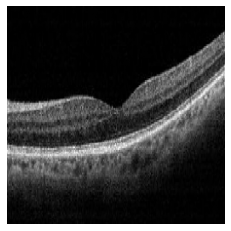

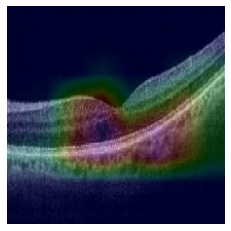

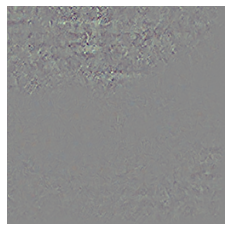

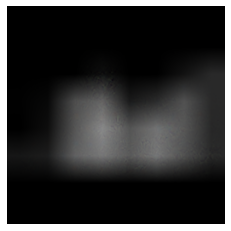

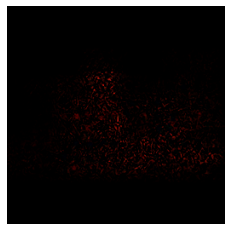

In [ ]:
#@title Run a Diagnostic Test {run: "auto", vertical-output: true}
image_index2 = 10 #@param {type:"slider", min:1, max:32, step:1}

testing_image2 = (image_batch2[image_index2 - 1] * 255).astype(np.uint8)
true_label2 = CLASSES[int(batch_labels2[image_index2 - 1])]
print('True Label', true_label2)
run_diagnosis(model, img_array=testing_image2)